# Getting Started with `feems` - wolves data set

Running an analysis on data set in [Schweizer et al. 2015](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW), similar to analyses in other notebooks...

In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from joblib import Parallel, delayed
from random import choices

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import plotly.express as px

# feems
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note we have packaged this example dataset in the `feems` package and use the `pkg_resources` package to find the path of those files:

In [3]:
data_path = pkg_resources.resource_filename("feems", "data/")

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [4]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 28.09it/s]

n_samples=111, n_snps=17729


In [5]:
%%time
# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 6.13 s, sys: 102 ms, total: 6.23 s
Wall time: 6.55 s


In [6]:
grid[:5, ]

array([[-166.637,   59.732],
       [-166.585,   60.675],
       [-166.529,   61.623],
       [-168.75 ,   62.088],
       [-166.467,   62.576]])

In [7]:
%%time
# wolves_graph = SpatialGraph(genotypes, coord, grid, edges)
wolves_graph = Joint_SpatialGraph(genotypes, coord, grid, edges)

CPU times: user 2min 8s, sys: 3.18 s, total: 2min 11s
Wall time: 2min 16s


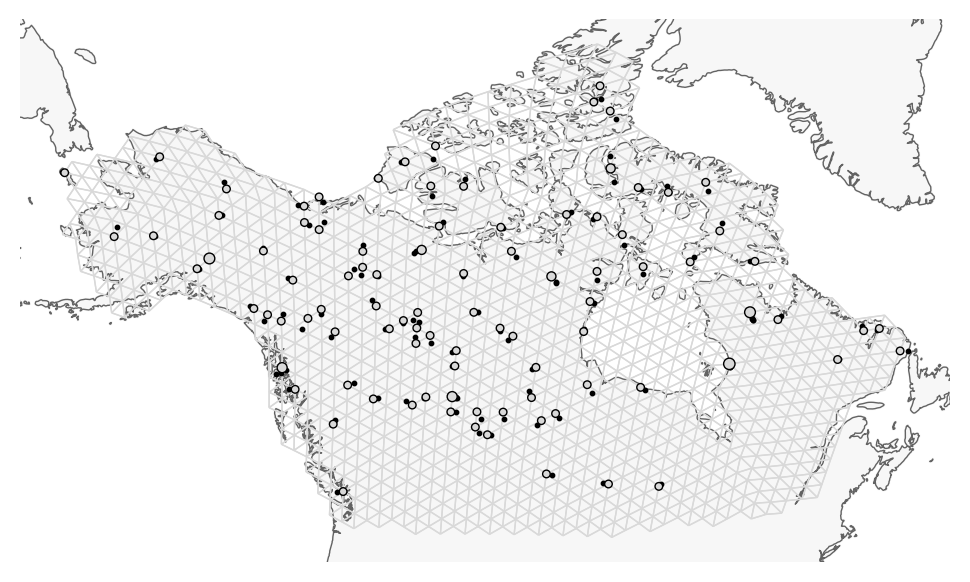

In [8]:
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)   
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [9]:
wolves_graph.fit(lamb=1., optimize_q='n-dim', lamb_q=100., alpha_q=1.0)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6520805
lambda=1.0000000, alpha=0.8354260, converged in 205 iterations, train_loss=2749233.3486094


Now we can visualize the weighted graph:

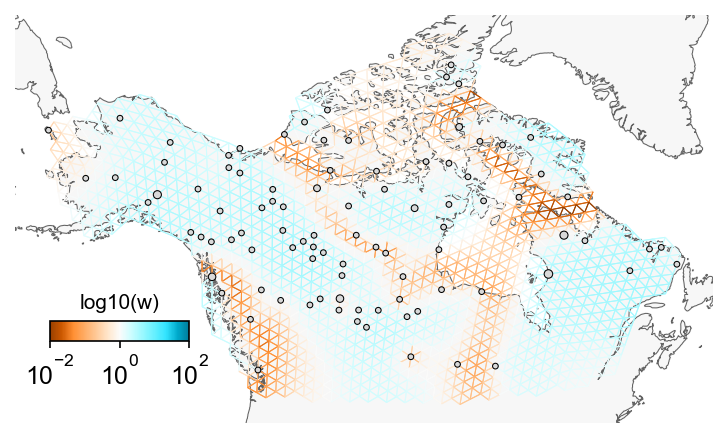

In [11]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

## Implementing a bootstrapping procedure to compute standard errors on fitted vs genetic distances

I will be sampling inds with replacement from each population (keeping the pop size constant). The source of variation is the sampling of inds from a fixed true pop size in each deme. 

In [117]:
wolves_graph.n_samples_per_obs_node_permuted[86:]

array([1, 5, 1, 1, 1, 1, 1, 1])

In [132]:
# nreps = 10
# rng = np.random.default_rng(2022); ss = rng.bit_generator._seed_seq; child_states = ss.spawn(nreps)
# fit_dist = np.zeros((wolves_graph.n_observed_nodes*(wolves_graph.n_observed_nodes-1)//2,nreps+1)); emp_dist = np.zeros_like(fit_dist)
## first column contains the results from the whole data set (not bootstrap replicates)
# obj = Joint_Objective(wolves_graph)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist[:,0] = cov_to_dist(fit_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
# emp_dist[:,0] = cov_to_dist(emp_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]

# def bootfun(seed,nsamps):
#     rng = np.random.default_rng(seed)
#     bootgenotypes = deepcopy(genotypes)
#     ctr = 0
#     for deme in range(len(nsamps)):
#         bootgenotypes[ctr:(ctr+nsamps[deme]),:] = genotypes[rng.choice(range(ctr,(ctr+nsamps[deme])),nsamps[deme]),:]
#         ctr += nsamps[deme]
#     temp_graph = Joint_SpatialGraph(bootgenotypes, coord, grid, edges)
#     temp_graph.fit(lamb=1., optimize_q='n-dim', lamb_q=1., alpha_q=1.0)
#     obj = Joint_Objective(temp_graph)
#     fit_cov, _, emp_cov = comp_mats(obj)
#     fit_dist = cov_to_dist(fit_cov)[np.tril_indices(len(nsamps), k=-1)]
#     emp_dist = cov_to_dist(emp_cov)[np.tril_indices(len(nsamps), k=-1)]
#     return [fit_dist, emp_dist]

# dists = Parallel(n_jobs=-1)(delayed(bootfun)(random_state,nsamps=wolves_graph.n_samples_per_obs_node_permuted) for random_state in child_states)

for n in range(1,nreps+1):
    fit_dist[:,n] = dists[n-1][0]; emp_dist[:,n] = dists[n-1][1]

# for n in range(1,nreps+1):
#     bootgenotypes = deepcopy(genotypes)
#     ctr = 0
#     for deme in range(wolves_graph.n_observed_nodes):
#         bootgenotypes[ctr:(ctr+wolves_graph.n_samples_per_obs_node_permuted[deme]),:100] = genotypes[rng.choice(range(ctr,(ctr+wolves_graph.n_samples_per_obs_node_permuted[deme])),wolves_graph.n_samples_per_obs_node_permuted[deme]),:100]
#         ctr += wolves_graph.n_samples_per_obs_node_permuted[deme]
#     wolves_graph = Joint_SpatialGraph(bootgenotypes, coord, grid, edges)
#     wolves_graph.fit(lamb=1., optimize_q='n-dim', lamb_q=1., alpha_q=1.0)
#     obj = Joint_Objective(wolves_graph)
#     fit_cov, _, emp_cov = comp_mats(obj)
#     fit_dist[:,n] = cov_to_dist(fit_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
#     emp_dist[:,n] = cov_to_dist(emp_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]

In [137]:
# plotting the result, by first drawing the regression line using the whole data set
# X = sm.add_constant(fit_dist[:,0])
# mod = sm.OLS(emp_dist[:,0], X)
# res = mod.fit()
# muhat, betahat = res.params
# computing the standard errors from before
# se_fit = np.zeros(fit_dist.shape[0]); se_emp = np.zeros_like(se_fit)
# for i in range(fit_dist.shape[0]):
#     se_fit[i] = np.sqrt(np.sum((fit_dist[i,:]-np.mean(fit_dist[i,:]))**2)/(nreps-1))
#     se_emp[i] = np.sqrt(np.sum((emp_dist[i,:]-np.mean(emp_dist[i,:]))**2)/(nreps-1))
# finding the largest outliers, taking into account the SE might overlap with best-fit line
max_idx = np.argpartition(res.resid, 100)[:100]
max_idx = max_idx[np.argsort(res.resid[max_idx])]
new_max_idx = []
for i in max_idx:
    if ((fit_dist[i,0]-se_fit[i])>(emp_dist[i,0]-muhat)/betahat) & ((betahat*fit_dist[i,0]+muhat) > (emp_dist[i,0]+se_emp[i])):
        new_max_idx.append(i)
# plotting the figure
# fig = plt.figure(dpi=80)
# ax = fig.add_subplot()
# ax.scatter(fit_dist[:,0], emp_dist[:,0], marker=".", alpha=0.75, zorder=0, color="grey", s=6)
# ax.errorbar(fit_dist[:,0],emp_dist[:,0],xerr=se_fit[:],yerr=se_emp[:], ecolor='grey', fmt='none',elinewidth=2,alpha=0.4)
# ax.scatter(fit_dist[new_max_idx,0], emp_dist[new_max_idx,0], marker=".", alpha=0.75, zorder=0, color="k", s=10)
# ax.errorbar(fit_dist[new_max_idx,0],emp_dist[new_max_idx,0],xerr=se_fit[new_max_idx],yerr=se_emp[new_max_idx], ecolor='k', fmt='none',elinewidth=2,alpha=0.6)
# x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
# ax.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
# ax.text(0.8, 0.05, "R²={:.3f}".format(res.rsquared), transform=ax.transAxes); plt.xlim((0,9)); plt.ylim((0,9))
# ax.set_ylabel("genetic distance")
# ax.set_xlabel("fitted distance")

## Running residual analysis on the wolves data

[(16, 18), (43, 68), (11, 13)]

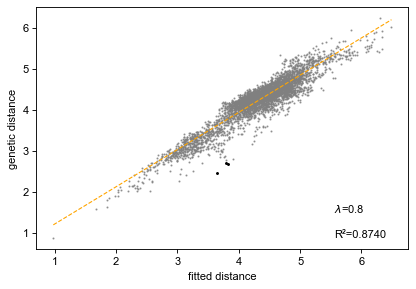

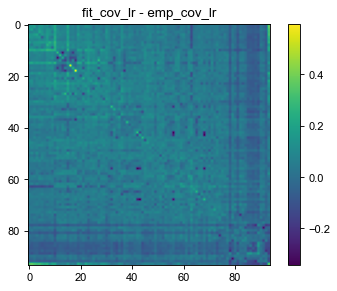

In [70]:
comp_genetic_vs_fitted_distance(wolves_graph_def, lamb=.8, lrn=[], plotFig=True, joint=True)

[(16, 18), (89, 93), (87, 93)]

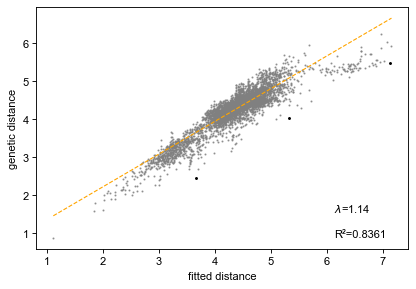

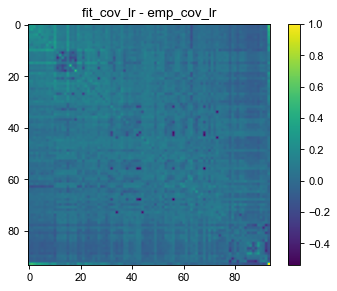

In [99]:
# there are no distinct outliers, but will see which nodes get returned as having the highest residuals
comp_genetic_vs_fitted_distance(wolves_graph_def_lr, lamb=1.14, lrn=[], plotFig=True, joint=True)

In [67]:
obj_def = Objective(wolves_graph_def)
obj_def.inv(); obj_def.neg_log_lik()

2760145.4930652156

In [133]:
wolves_graph_def.fit(.8)
max_res_nodes = comp_genetic_vs_fitted_distance(wolves_graph_def, lamb=0.8, plotFig=False, n_lre=20)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6520805
lambda=0.80000, alpha=0.83543, beta=0.00000, converged in 94 iterations, train_loss=2761323.98444


In [134]:
# looks like nodes around 11, 17, 42, 56, 67 are in the mix (ignoring nodes that are within the same 'population' group)
max_res_nodes

[(16, 18),
 (43, 68),
 (11, 13),
 (42, 68),
 (42, 56),
 (13, 16),
 (18, 37),
 (13, 18),
 (11, 17),
 (56, 68),
 (14, 18),
 (12, 18),
 (12, 16),
 (11, 16),
 (32, 42),
 (32, 56),
 (16, 65),
 (18, 33),
 (16, 33),
 (32, 68)]

In [33]:
# only look for nodes that are representative of sampled populations...
permuted_idx = query_node_attributes(wolves_graph, "permuted_idx")
obs_perm_ids = permuted_idx[: wolves_graph.n_observed_nodes]
obs_grid = grid[obs_perm_ids, :]

In [35]:
## code for mapping nodes back to populations (since multiple pops can be assigned to the same nodes)
node_to_pop = pd.DataFrame(index = np.arange(wolves_graph.n_observed_nodes), columns = ['nodes', 'pops'])
node_to_pop['nodes'] = obs_perm_ids
node_to_pop['pops'] = [query_node_attributes(wolves_graph,"sample_idx")[x] for x in obs_perm_ids]

In [36]:
node_to_pop

nodes   pops
0      35  [105]
1      42  [106]
2      71  [108]
3      90  [107]
4     102  [104]
..    ...    ...
89    980   [39]
90    989   [52]
91   1078    [0]
92   1124    [1]
93   1206  [102]

[94 rows x 2 columns]

In [121]:
obj = Joint_Objective(wolves_graph); obj.inv(); print(obj.neg_log_lik())
obj_lr_jt.neg_log_lik()

2746889.7268236573


2779907.8156564976

In [87]:
lrn = list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)[0:20]].values.reshape(10,2)))
edges_lr = deepcopy(edges)
edges_lr = edges_lr.tolist()
for x in lrn:
    edges_lr.append(list(tuple(y+1 for y in x)))

In [135]:
max_res_nodes_jt = comp_genetic_vs_fitted_distance(wolves_graph, lamb=0.8, plotFig=False, n_lre=20)
max_res_nodes_jt

[(89, 93),
 (10, 89),
 (15, 89),
 (8, 89),
 (79, 91),
 (7, 89),
 (1, 89),
 (46, 89),
 (34, 89),
 (31, 89),
 (6, 89),
 (66, 89),
 (24, 89),
 (26, 89),
 (30, 89),
 (5, 89),
 (81, 93),
 (18, 89),
 (12, 89),
 (36, 89)]

In [93]:
# lamb_grid = np.geomspace(1e-6, 2e2, 20)[::-1]
# cv_err = run_cv(wolves_graph_def_lr, lamb_grid, n_folds=20, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
wolves_graph.fit(lamb=1000*lamb_cv)

constant-w/variance fit, converged in 129 iterations, train_loss=2794593.5316744
lambda=1.14360, alpha=0.90605, beta=0.00000, converged in 7 iterations, train_loss=2770497.34354


In [117]:
ll_def_inc = np.zeros(len(max_res_nodes))
for ie, e in enumerate(max_res_nodes):
    edges_lr = deepcopy(edges)
    edges_lr = edges_lr.tolist()
    edges_lr.append(list(tuple(y+1 for y in e)))
    wolves_graph_lr = SpatialGraph(genotypes, coord, grid, np.array(edges_lr), long_range_edges=[e])
    wolves_graph_lr.fit(lamb=1.)
    obj_lr = Objective(wolves_graph_lr); obj_lr.inv()
    ll_def_inc[ie] = obj_def.neg_log_lik() - obj_lr.neg_log_lik()

# ll_inc = np.zeros(len(max_res_nodes_jt))
# for ie, e in enumerate(max_res_nodes_jt):
#     edges_lr = deepcopy(edges)
#     edges_lr = edges_lr.tolist()
#     edges_lr.append(list(tuple(y+1 for y in e)))
#     wolves_graph_jt = Joint_SpatialGraph(genotypes, coord, grid, np.array(edges_lr), long_range_edges=[e])
#     wolves_graph_jt.fit(lamb=100., optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(wolves_graph_jt.s2))
#     obj_lr_jt = Joint_Objective(wolves_graph_jt); obj_lr_jt.inv()
#     ll_inc[ie] = obj.neg_log_lik() - obj_lr_jt.neg_log_lik()

constant-w/variance fit, converged in 129 iterations, train_loss=2795613.8933178
lambda=100.0000000, alpha=0.8373052, converged in 9 iterations, train_loss=2779924.3725551
constant-w/variance fit, converged in 125 iterations, train_loss=2795639.6562600
lambda=100.0000000, alpha=0.8382483, converged in 15 iterations, train_loss=2775538.7467311
constant-w/variance fit, converged in 125 iterations, train_loss=2795577.2078341
lambda=100.0000000, alpha=0.8389886, converged in 9 iterations, train_loss=2779860.8421559
constant-w/variance fit, converged in 127 iterations, train_loss=2795656.6222914
lambda=100.0000000, alpha=0.8387006, converged in 15 iterations, train_loss=2775460.9562856
constant-w/variance fit, converged in 135 iterations, train_loss=2795675.3575696
lambda=100.0000000, alpha=0.8354994, converged in 9 iterations, train_loss=2779965.9187221
constant-w/variance fit, converged in 126 iterations, train_loss=2795768.1045301
lambda=100.0000000, alpha=0.8383310, converged in 19 iter

Text(0.5, 0, 'edge id')

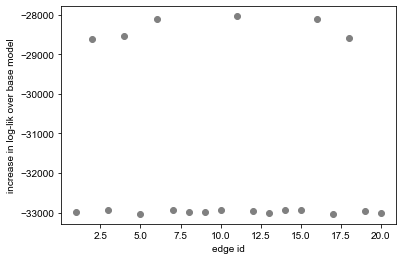

In [132]:
plt.scatter(np.arange(1,len(max_res_nodes)+1), ll_inc, color='grey', label='joint'); plt.ylabel('increase in log-lik over base model')
plt.scatter(np.arange(1,len(max_res_nodes)+1), ll_def_inc, color='k', label='default'); plt.xlabel('edge id'); plt.legend()

In [98]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph_def_lr, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

TypeError: '<=' not supported between instances of 'list' and 'int'

In [105]:
# lamb_grid = np.geomspace(1e-6, 2e2, 20)[::-1]
# cv_err = run_cv(wolves_graph_lr, lamb_grid, n_folds=20, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
# wolves_graph_lr = Joint_SpatialGraph(genotypes, coord, grid, np.array(edges_lr), long_range_edges=lrn)
wolves_graph_lr.fit(lamb=1e+6*lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1.0)

constant-w/variance fit, converged in 121 iterations, train_loss=2796614.4506189
lambda=1.0000000, alpha=1.0805750, converged in 80 iterations, train_loss=2745987.0927682


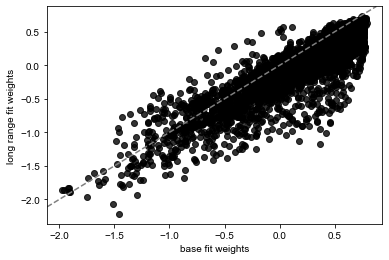

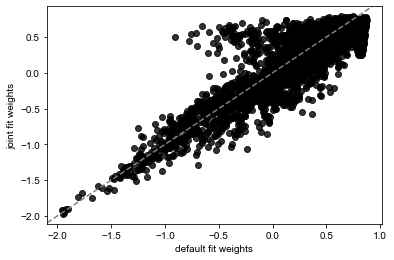

In [72]:
# plotting joint fit vs long range edges fit weights
plt.scatter(np.log10(wolves_graph.w), np.log10(wolves_graph_lr.w[~wolves_graph_lr.lre_idx]),alpha=0.8,color='k')
plt.xlabel('base fit weights'); plt.ylabel('long range fit weights'); plt.axline((0,0),(-1,-1),color='grey',ls='--'); plt.show()
# plotting default weights vs joint fit weights
plt.scatter(np.log10(wolves_graph_def.w), np.log10(wolves_graph.w),alpha=0.8,color='k')
plt.xlabel('default fit weights'); plt.ylabel('joint fit weights'); plt.axline((0,0),(-1,-1),color='grey',ls='--')

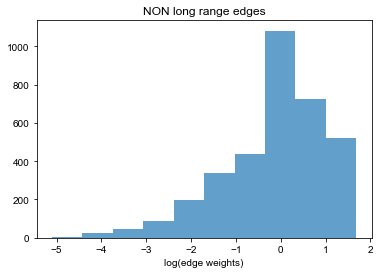

Text(0.5, 0, 'log(edge weights)')

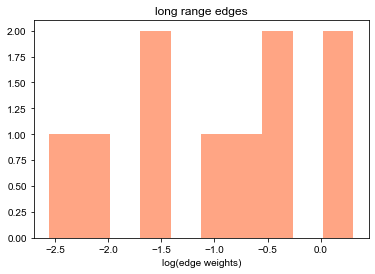

In [43]:
plt.hist(np.log(wolves_graph_lr.w[~wolves_graph_lr.lre_idx]),alpha=0.7)
plt.title('NON long range edges')
plt.xlabel('log(edge weights)')
plt.show()
plt.hist(np.log(wolves_graph_lr.w[wolves_graph_lr.lre_idx]),color='coral',alpha=0.7)
plt.title('long range edges')
plt.xlabel('log(edge weights)')

In [123]:
nll = np.empty(10)
edges_lr = deepcopy(edges)
edges_lr = edges_lr.tolist()
for idx in np.arange(len(nll)):
    for x in node_to_pop['nodes'][np.ravel(max_res_nodes)[idx*2:((idx+1)*2)]].values.reshape(1,2):
        #print([(x[0],x[1])])        
        edges_lr.append(list(tuple(y+1 for y in x)))    
    wolves_graph_lr = Joint_SpatialGraph(genotypes, coord, grid, np.array(edges_lr), long_range_edges=max_res_nodes[:idx])
    wolves_graph_lr.fit(lamb=1.1, optimize_q='n-dim', lamb_q=1., alpha_q=1.0)
    obj_lr = Joint_Objective(wolves_graph_lr)
    obj_lr.inv()
    nll[idx] = obj_lr.neg_log_lik()

constant-w/variance fit, converged in 133 iterations, train_loss=2794612.0002715
lambda=1.1000000, alpha=0.9199442, converged in 195 iterations, train_loss=2745186.9660904
constant-w/variance fit, converged in 135 iterations, train_loss=2794613.9636699
lambda=1.1000000, alpha=0.9661957, converged in 185 iterations, train_loss=2744974.7037078
constant-w/variance fit, converged in 122 iterations, train_loss=2795010.0328693
lambda=1.1000000, alpha=0.9794459, converged in 101 iterations, train_loss=2745449.5141075
constant-w/variance fit, converged in 131 iterations, train_loss=2795383.3118592
lambda=1.1000000, alpha=0.9847974, converged in 237 iterations, train_loss=2744911.9727965
constant-w/variance fit, converged in 132 iterations, train_loss=2795207.5343679
lambda=1.1000000, alpha=0.9967912, converged in 100 iterations, train_loss=2745210.8995281
constant-w/variance fit, converged in 142 iterations, train_loss=2795531.6957538
lambda=1.1000000, alpha=0.9975164, converged in 105 iterati

Text(0.5, 0, 'number of edges')

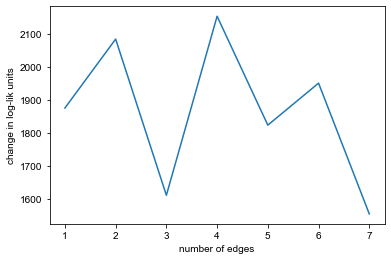

In [129]:
plt.plot(np.arange(1,8),obj.neg_log_lik()-nll[:7],'-')
plt.ylabel('change in log-lik units')
plt.xlabel('number of edges')

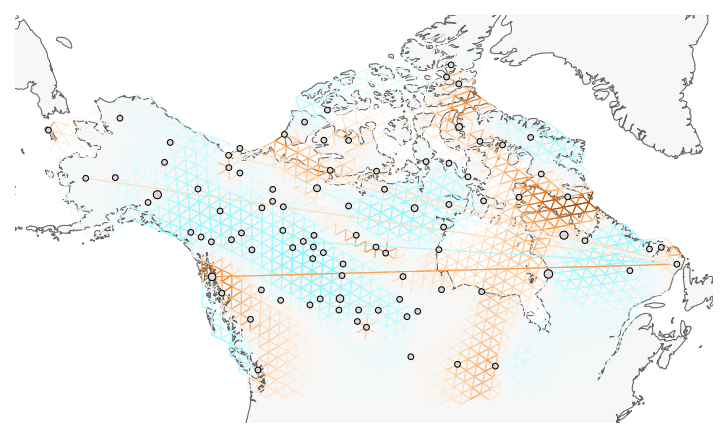

In [106]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, wolves_graph_lr, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

[(81, 89), (88, 89), (87, 89)]

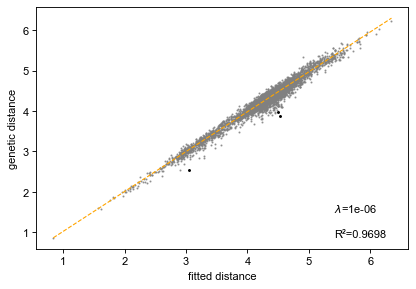

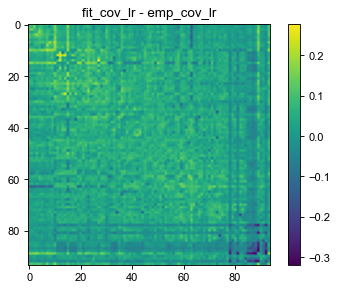

In [107]:
comp_genetic_vs_fitted_distance(wolves_graph_lr, lrn=[], lamb=1e-6, plotFig=True)S

In [100]:
obj_lr = Objective(wolves_graph_lr)
obj_lr.inv(); obj_lr.neg_log_lik()

2745461.6879508863

In [74]:
# Plot Observed vs Fitted Covariances and residuals
obj = Objective(wolves_graph)
fit_cov, _, emp_cov = comp_mats(obj)
# Set diagonals to zero to focus on covariances
np.fill_diagonal(fit_cov,0)
np.fill_diagonal(emp_cov,0)

In [91]:
res_mat = fit_cov - emp_cov
# res_mat[np.tril_indices_from(res_mat,k=-1)]

In [104]:
px.imshow(res_mat)

(array([   4.,    5.,   10.,   44.,  364., 1472., 2212.,  225.,   28.,
           7.]),
 array([-1.30362968, -1.08128991, -0.85895014, -0.63661037, -0.4142706 ,
        -0.19193083,  0.03040894,  0.25274871,  0.47508848,  0.69742825,
         0.91976802]),
 <a list of 10 Patch objects>)

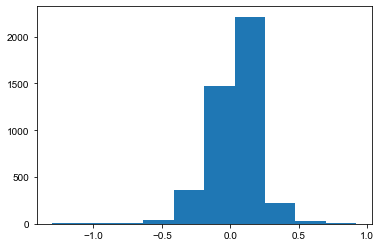

In [83]:
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(wolves_graph.n_observed_nodes, k=-1)]

# using code from supp fig 6 of feems-analysis
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()

plt.hist(res.resid - res_mat[np.tril_indices_from(res_mat,k=-1)])

Text(0, 0.5, 'diff bw matrices of fitted and empirical covariances')

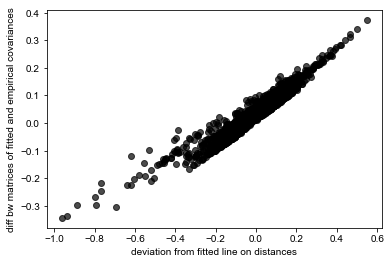

In [114]:
plt.scatter(res.resid, res_mat[np.tril_indices_from(res_mat,k=-1)], color='k', alpha=0.7)
plt.xlabel('deviation from fitted line on distances')
plt.ylabel('diff bw matrices of fitted and empirical covariances')
# plt.axline((0,0),(-1,-1),color='red',ls='--')

In [118]:
print(res.resid[np.argsort(res.resid)])
res_mat[np.tril_indices_from(res_mat,k=-1)][np.argsort(res_mat[np.tril_indices_from(res_mat,k=-1)])]

[-0.96035102 -0.93605697 -0.88702905 ...  0.46714942  0.49768303
  0.54776522]


array([-0.34327867, -0.33708365, -0.30283848, ...,  0.32309702,
        0.34113422,  0.3720028 ])

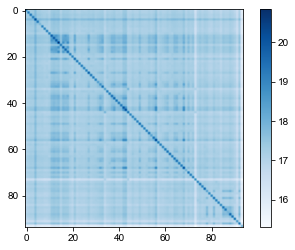

In [122]:
plt.imshow(wolves_graph.S, cmap='Blues')
plt.colorbar()

### Regularization path analysis

In [124]:
betas = np.logspace(-2,5,base=np.exp(1),num=20) # -0.01 to 400
metricsdf2 = pd.DataFrame(index=range(len(betas)),columns=["loss","log_lik","pen1","pen2"])
metricsdf = deepcopy(metricsdf2)
metricsdf2['betas'] = betas
for n in np.arange(5):
    for ib, b in enumerate(betas):
        wolves_graph_lr.fit(lamb=1.1, beta=b)
        metricsdf2.loc[ib,"loss"] = wolves_graph_lr.train_loss
        obj_lr = Objective(wolves_graph_lr)
        obj_lr.lamb = 1.1
        obj_lr.alpha = 1/wolves_graph_lr.w0.mean()
        obj_lr.beta = b
        obj_lr.inv() 
        metricsdf2.loc[ib,"log_lik"] = -obj_lr.neg_log_lik()
        obj_lr.loss()
        metricsdf2.loc[ib,"pen1"] = obj_lr.pen1
        metricsdf2.loc[ib,"pen2"] = obj_lr.pen2#b * np.sum(sp_graph_lr.w[sp_graph_lr.lre_idx])

    print(metricsdf2)
    metricsdf = metricsdf + metricsdf2

onverged in 129 iterations, train_loss=2794593.5316744
lambda=1.10000, alpha=0.90605, beta=5.38820, converged in 39 iterations, train_loss=2762607.20208
constant-w/variance fit, converged in 129 iterations, train_loss=2794593.5316744
lambda=1.10000, alpha=0.90605, beta=7.78837, converged in 47 iterations, train_loss=2762465.27771
constant-w/variance fit, converged in 129 iterations, train_loss=2794593.5316744
lambda=1.10000, alpha=0.90605, beta=11.25770, converged in 52 iterations, train_loss=2762459.94861
constant-w/variance fit, converged in 129 iterations, train_loss=2794593.5316744
lambda=1.10000, alpha=0.90605, beta=16.27245, converged in 64 iterations, train_loss=2762508.10069
constant-w/variance fit, converged in 129 iterations, train_loss=2794593.5316744
lambda=1.10000, alpha=0.90605, beta=23.52103, converged in 65 iterations, train_loss=2762614.89163
constant-w/variance fit, converged in 129 iterations, train_loss=2794593.5316744
lambda=1.10000, alpha=0.90605, beta=33.99848, c

KeyboardInterrupt: 

[]

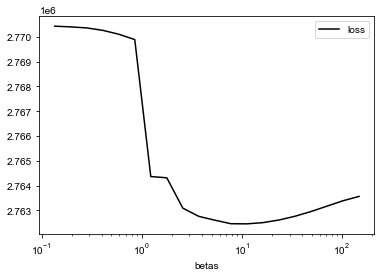

In [129]:
metricsdf2.plot(x='betas',y=["log_lik","pen1","pen2"],kind='line')
plt.ylabel('units')
plt.loglog()
metricsdf2.plot(x='betas',y=["log_lik"],kind='line')
plt.semilogx()
metricsdf2.plot(x='betas',y=['pen1'],kind='line',color='orange')
plt.semilogx()
metricsdf2.plot(x='betas',y='loss',color='black')
plt.semilogx()

Text(0, 0.5, 'sum of long range weights')

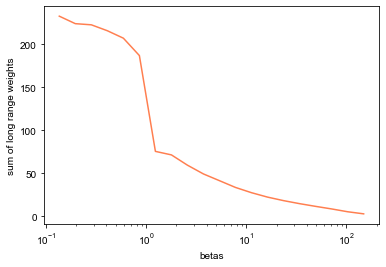

In [128]:
plt.plot(metricsdf2['betas'],metricsdf2['pen2']/metricsdf2['betas'],color='coral')
plt.xlabel('betas')
plt.semilogx()
plt.ylabel('sum of long range weights')

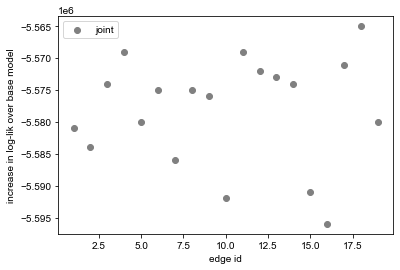

In [6]:
ll_inc = np.array([5.581,5.584,5.574,5.569,5.58,5.575,5.586,5.575,5.576,5.592,5.569,5.572,5.573,5.574,5.591,5.596,5.571,5.565,5.580])*-1e6
plt.scatter(np.arange(1,20), ll_inc, color='grey', label='joint'); plt.ylabel('increase in log-lik over base model'); 
# plt.scatter(np.arange(1,len(max_res_nodes)+1), ll_def_inc, color='k', label='default'); 
plt.xlabel('edge id'); plt.legend()